In [1]:
%cd ../../

/work/pancreas/psebe/assinaturas_mutacionais


In [2]:
import pymc3 as pm

In [3]:
import pandas as pd
import pymc3 as pm
import numpy as np
import seaborn as sns
import arviz as az
from matplotlib import pyplot as plt

## Data import

In [4]:
dtypes = dict(
    Tumor_Sample_Barcode=str,
    Chromosome="category",
    Start_Position=int,
    Reference_Allele="category",
    Tumor_Seq_Allele2="category",
    Hugo_Symbol=str,
    Consequence="category",
    Variant_Classification="category",
    DNA_VAF=float,
    Substitution="category"
)

In [5]:
mutations = pd.read_table("results/mutations_with_context.txt", dtype=dtypes, usecols=dtypes.keys())

In [6]:
mutational_catalogues = mutations.groupby(["Tumor_Sample_Barcode","Substitution"]).size().unstack(fill_value=0)

In [7]:
assert len(mutational_catalogues.columns) == 96

count    2683.000000
mean        3.930215
std         1.278081
min         0.000000
25%         3.258097
50%         4.007333
75%         4.634729
max         9.607370
dtype: float64

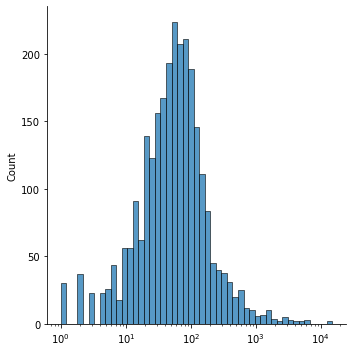

In [8]:
sns.displot(mutational_catalogues.sum(axis=1), log_scale=True)
np.log(mutational_catalogues.sum(axis=1)).describe()

In [9]:
info_clinica = pd.read_table(
    "resources/pancan_pcawg_2020/data_clinical_sample.txt",
    index_col="SAMPLE_ID",
    comment="#")

In [10]:
histology = info_clinica.loc[mutational_catalogues.index, "HISTOLOGY_ABBREVIATION"].astype("category")

## COSMIC signatures import

In [11]:
sigs = pd.read_table("resources/COSMIC_v3.2_SBS_GRCh37.txt", index_col="Type").T

In [12]:
assert (sigs.columns == mutational_catalogues.columns).all()

## Statistical model

- ADVI
- Assinaturas fixas (COSMIC v3.2)
- Sem hiperdispersão
- Levando em conta tipo tumoral (partial pooling)
- Priori de Dirichlet

In [13]:
n = len(mutational_catalogues)
k, p = sigs.shape
t = len(histology.cat.categories)

In [14]:
coords = dict(
    Sample = mutational_catalogues.index,
    Signature = sigs.index,
    Substitution = sigs.columns,
    Histology=histology.cat.categories
)

In [15]:
with pm.Model(coords=coords) as model:
    alpha_loc = pm.Exponential("α (overall)", 1, dims="Signature")
    alpha_z = pm.Normal("α (log-noncentered)", dims=("Histology","Signature"))
    alpha_scale = pm.HalfNormal("log(α) SD", dims="Signature")
    alpha = pm.Deterministic("α", alpha_loc * np.exp(alpha_z * alpha_scale), dims=("Histology","Signature"))
    exposure = pm.Dirichlet("Exposure", alpha[histology.cat.codes.values],
                            dims=("Sample","Signature"))
    pm.Multinomial("Mutational catalogue",
                        n = mutational_catalogues.sum(axis=1),
                        p = pm.math.dot(exposure, sigs.values),
                        dims=("Sample", "Substitution"),
                        observed=mutational_catalogues.values)

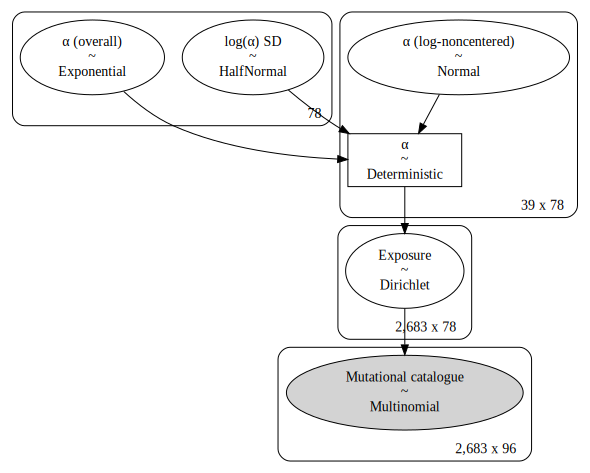

In [16]:
pm.model_to_graphviz(model)

In [17]:
with model:
    mean_field = pm.fit(
        n=2000,
        obj_optimizer=pm.adam(learning_rate=0.01),
        callbacks=[pm.callbacks.CheckParametersConvergence(every=50)])

Finished [100%]: Average Loss = 3.0376e+05


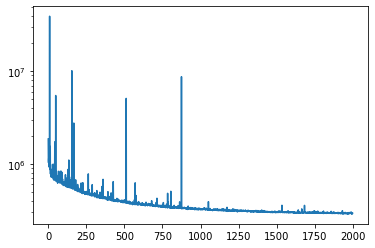

In [180]:
plt.plot(mean_field.hist)
plt.yscale("log")

In [19]:
trace = mean_field.sample()

## Interpretação do modelo

### Coeficientes $\alpha$ por tipo tumoral

O plot a seguir mostra os alfas estimados pelo modelo. Cada círculo representa um tipo tumoral, e as barras pretas representam a mediana entre os tipos. A linha tracejada no centro representa $\alpha=1$, equivalente a uma distribuição uniforme. Esse plot tem algumas características interessantes:
- SBS1 (idade) e SBS6 (MMR) estão hiperrepresentadas em todos os tipos;
- SBS87 (tiopurina) também, o que faz pouco sentido;
- SBS7a/b (UV) estão associada a pele e SBS4 (tabaco) a pulmão;
- SBS17b (ROS/5FU) está associada a adenocarcinoma de esôfago;
- SBS24 (Aflatoxina) está associada a pulmão em vez de fígado.

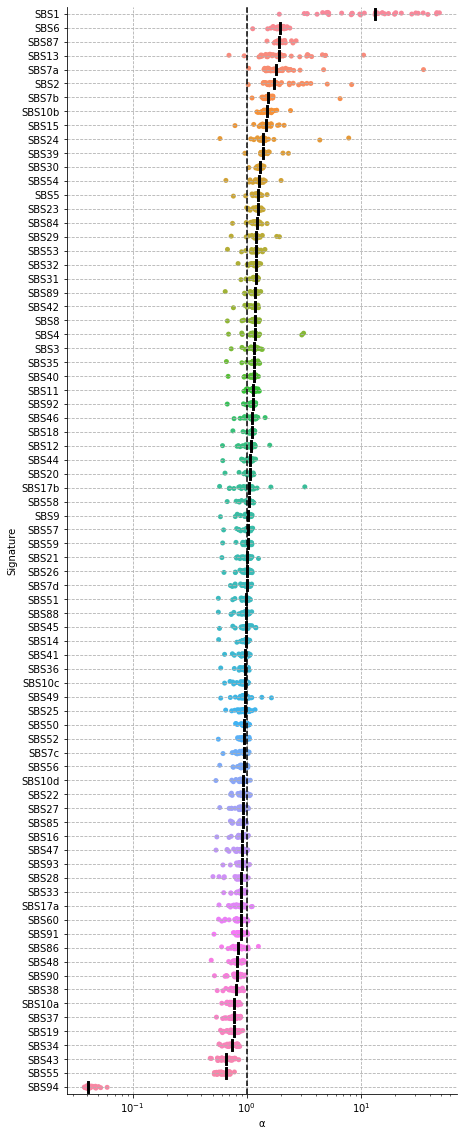

In [120]:
df = (
    pd.DataFrame(
        trace["α"].mean(axis=0), 
        index=coords["Histology"], 
        columns=coords["Signature"])
    .stack()
    .reset_index()
    .rename(columns={"level_0":"Histology", "level_1":"Signature", 0:"α"})
)
plt.figure(figsize=(7,20))
p = sns.stripplot(
    data=df,
    y="Signature",
    x="α",
    zorder=0
)
sns.pointplot(
    x="α",
    y="Signature",
    data=df,
    order=df.groupby("Signature").median()["α"].sort_values(ascending=False).index,
    estimator=np.median,
    ax=p,
    join=False,
    ci=0,
    capsize=.7,
    scale=0,
    color="black",
    zorder=+3)
plt.axvline(1, ls="--", c="k")
plt.grid(ls="--")
plt.xscale("log")
sns.despine()

In [179]:
df[df["Signature"]=="SBS24"].sort_values("α", ascending=False).head()

,Histology,Signature,α
1824,Lung-SCC,SBS24,7.803963
1746,Lung-AdenoCA,SBS24,4.353172
1668,Liver-HCC,SBS24,1.726254
2292,Ovary-AdenoCA,SBS24,1.543166
1590,Kidney-RCC,SBS24,1.490995
